<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 5 - Support Vector Machine Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[SVM Classifier with Simple Features](#knn-simple)  
[SVM Classifier with Full Features](#knn-full)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Calibration with Isotonic Scaling](#calibration)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the Support Vector Machine classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'svm'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# SVM with simple features <a class="anchor" id="svm-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

SVM can take a long time to run, especially on large datasets. Beause of this, we'll add a `SUBSAMPLE` variable to downsample the size of the dataset by default. To run these algorithms across all of the data, set `SUBSAMPLE = 1`. Results will not match the published results when the notebook only uses a portion of the training data.

In [3]:
SUBSAMPLE = 0.1

def subsample(X, y, w, stratify=True, seed=566):
    n_samples = int(SUBSAMPLE * X.shape[0])
    
    rng = np.random.RandomState(seed)
    
    if stratify:
        y_rate = y.mean()
        n_true = int(n_samples * y_rate)
        n_false = n_samples - n_true
        
        true_idx = rng.choice(np.where(y)[0], n_true, replace=False)
        false_idx = rng.choice(np.where(~y)[0], n_false, replace=False)
        
        sample_idx = np.union1d(true_idx, false_idx)
    else:
        sample_idx = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    
    return X.iloc[sample_idx, :], y[sample_idx], w[sample_idx]

In [4]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


CPU times: user 6.35 s, sys: 4.6 ms, total: 6.36 s
Wall time: 10.3 s
CPU times: user 437 ms, sys: 1.92 ms, total: 439 ms
Wall time: 709 ms
In-sample score: 91.02%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


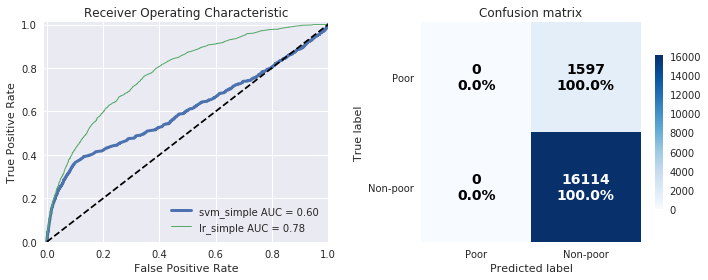

,svm_simple,lr_simple
accuracy,0.90983,0.91158
recall,0,0.0851597
precision,0,0.564315
f1,0,0.147987
cross_entropy,0.29088,0.256817
roc_auc,0.604869,0.781848
cohen_kappa,0,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 0.01% 


In [5]:
from sklearn.svm import SVC

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

It appears that the SVM is essentially predicting almost every household to be non-poor. This is a clear sign that we need to deal with the unbalanced classes. The `SVC` model includes a `class_weight` parameter, so let's use this and see if it helps.

CPU times: user 9.67 s, sys: 75.2 ms, total: 9.74 s
Wall time: 17.5 s
CPU times: user 1.1 s, sys: 199 µs, total: 1.1 s
Wall time: 2.28 s
In-sample score: 73.97%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


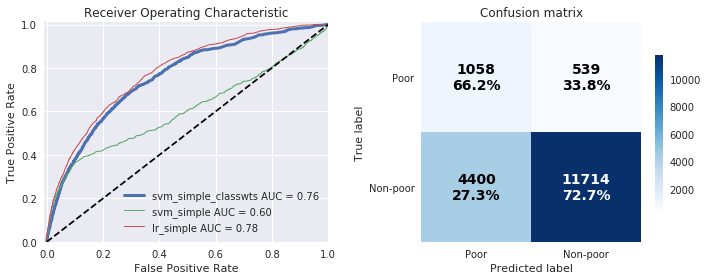

,svm_simple_classwts,svm_simple,lr_simple
accuracy,0.721134,0.90983,0.91158
recall,0.662492,0,0.0851597
precision,0.193844,0,0.564315
f1,0.299929,0,0.147987
cross_entropy,0.265608,0.29088,0.256817
roc_auc,0.758437,0.604869,0.781848
cohen_kappa,0.186421,0,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 35.36% 


In [6]:
from sklearn.svm import SVC

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

X_train, y_train, w_train = subsample(X_train, y_train, w_train)

# Fit the model
model = SVC(probability=True, class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['svm_simple', 
                                                    'lr_simple'],
                                    store_model=True,
                                    model_name='simple_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# SVM with all features <a class="anchor" id="all-feats"></a>

Now let's apply the SVM classifier to the dataset with all features. One of the drawbacks of SVMs is that they are very slow to train on large datasets with large numbers of features. Many of the following cells may take a long time to run.

CPU times: user 28.7 s, sys: 62.2 ms, total: 28.7 s
Wall time: 39.1 s
CPU times: user 4.42 s, sys: 0 ns, total: 4.42 s
Wall time: 5.8 s
In-sample score: 89.44%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


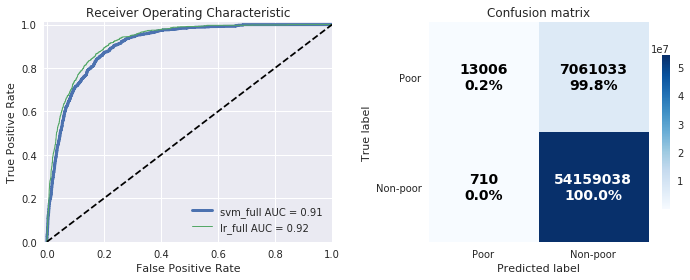

,svm_full,lr_full
accuracy,0.884676,0.910251
recall,0.00183853,0.456232
precision,0.948268,0.661838
f1,0.00366995,0.540131
cross_entropy,0.229268,0.212947
roc_auc,0.909888,0.923198
cohen_kappa,0.00669955,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 0.02% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

X_train, y_train, w_train = subsample(X_train, y_train, w_train)

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

This model has a very low recall rate, so we are not doing well at identifying the actual Poor households. Once again, we will need to balance the classes using one of the methods we've used in previous notebooks.

## Class Weighting
Since we have the option of using class weights, let's see how it performs with SVM.

NOTE: The following cell may take over an hour to run.

CPU times: user 1min 1s, sys: 117 ms, total: 1min 1s
Wall time: 1min 40s
CPU times: user 10.2 s, sys: 8.01 ms, total: 10.2 s
Wall time: 24.4 s
In-sample score: 83.35%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


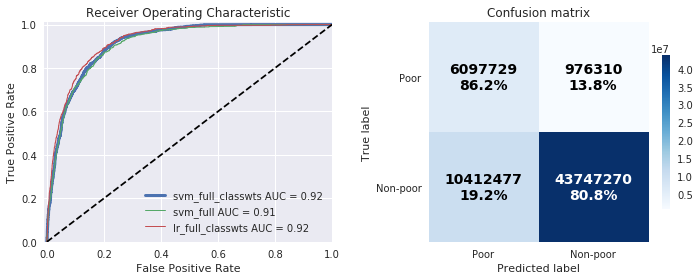

,svm_full_classwts,svm_full,lr_full_classwts
accuracy,0.814011,0.884676,0.830513
recall,0.861987,0.00183853,0.866754
precision,0.369331,0.948268,0.39387
f1,0.517102,0.00366995,0.541618
cross_entropy,0.221189,0.229268,0.384733
roc_auc,0.915038,0.909888,0.923196
cohen_kappa,0.384742,0.00669955,0.428159


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.39% 


In [8]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

# Fit the model
model = SVC(probability=True, class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full', 
                                                    'lr_full_classwts'],
                                    store_model=True,
                                    model_name='full_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

Class weighting improves the recall rate significantly.

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

X shape after undersampling:  (958, 453)
CPU times: user 2.19 s, sys: 0 ns, total: 2.19 s
Wall time: 4.33 s
CPU times: user 429 ms, sys: 0 ns, total: 429 ms
Wall time: 768 ms
In-sample score: 85.59%
CPU times: user 7.98 s, sys: 86.1 ms, total: 8.07 s
Wall time: 13.3 s
CPU times: user 8.09 s, sys: 74.6 ms, total: 8.17 s
Wall time: 11.2 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


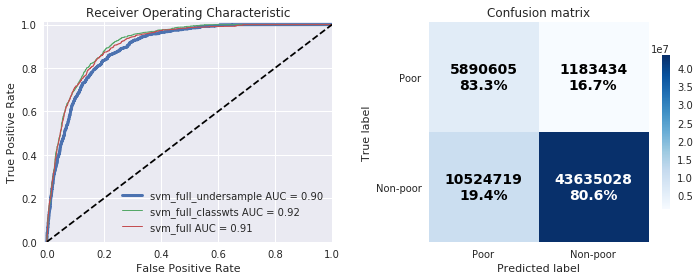

,svm_full_undersample,svm_full_classwts,svm_full
accuracy,0.808796,0.814011,0.884676
recall,0.832707,0.861987,0.00183853
precision,0.358848,0.369331,0.948268
f1,0.501555,0.517102,0.00366995
cross_entropy,0.376842,0.221189,0.229268
roc_auc,0.8967,0.915038,0.909888
cohen_kappa,0.32636,0.384742,0.00669955


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.38% 


In [9]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full_classwts', 
                                                    'svm_full'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Oversampling <a class="anchor" id="oversampling">

NOTE: Since oversampling greatly increases the size of the dataset, the following cell will take a very long time to run.

X shape after oversampling:  (9668, 453)
CPU times: user 2min 34s, sys: 627 ms, total: 2min 35s
Wall time: 4min 3s
CPU times: user 25.6 s, sys: 32.9 ms, total: 25.6 s
Wall time: 40.6 s
In-sample score: 93.59%
CPU times: user 46.6 s, sys: 169 ms, total: 46.8 s
Wall time: 1min 16s
CPU times: user 46.6 s, sys: 147 ms, total: 46.7 s
Wall time: 1min 13s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


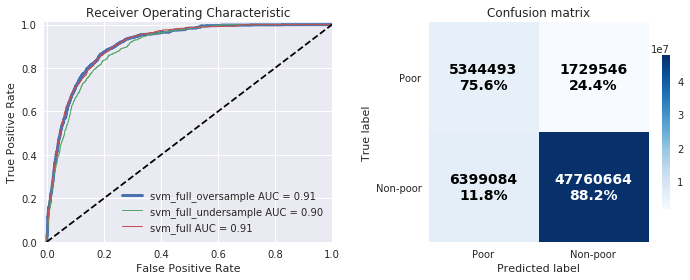

,svm_full_oversample,svm_full_undersample,svm_full
accuracy,0.867253,0.808796,0.884676
recall,0.755508,0.832707,0.00183853
precision,0.455099,0.358848,0.948268
f1,0.568031,0.501555,0.00366995
cross_entropy,0.305525,0.376842,0.229268
roc_auc,0.909297,0.8967,0.909888
cohen_kappa,0.454544,0.32636,0.00669955


Actual poverty rate: 11.38% 
Predicted poverty rate: 18.87% 


In [10]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full_undersample', 
                                                    'svm_full'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

Now we try to find the best value for `C` as we did with the Malawi dataset. Since SVM takes a long time to train for larger datasets, we'll use undersampling to balance the classes.

NOTE: The following cell may take over an hour to run.

X shape after undersampling:  (958, 453)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   14.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.8s finished


CPU times: user 2.57 s, sys: 528 ms, total: 3.1 s
Wall time: 18.7 s
CPU times: user 309 ms, sys: 0 ns, total: 309 ms
Wall time: 749 ms
In-sample score: 88.31%
Best model parameters: {'C': 0.01, 'kernel': 'linear'}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


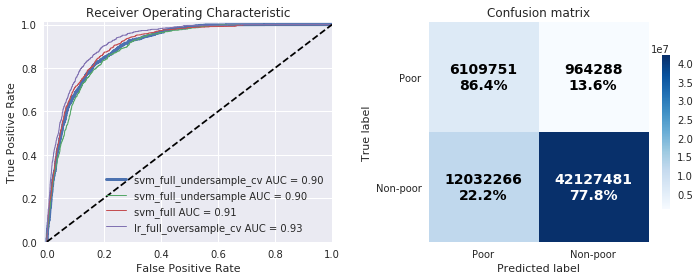

,svm_full_undersample_cv,svm_full_undersample,svm_full,lr_full_oversample_cv
accuracy,0.787755,0.808796,0.884676,0.851611
recall,0.863686,0.832707,0.00183853,0.838116
precision,0.336774,0.358848,0.948268,0.427456
f1,0.484592,0.501555,0.00366995,0.566159
cross_entropy,0.41083,0.376842,0.229268,0.348544
roc_auc,0.903882,0.8967,0.909888,0.925356
cohen_kappa,0.342357,0.32636,0.00669955,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 29.34% 


In [11]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = SVC(probability=True)
parameters = {'C': 10**np.linspace(-4,1,6), 
              'kernel': ['rbf', 'linear']}
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full_undersample', 
                                                    'svm_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

# Classifier Calibration with Isotonic Regression <a class="anchor" id="calibration"></a>

X shape after undersampling:  (958, 453)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.6s finished


CPU times: user 4.35 s, sys: 671 ms, total: 5.02 s
Wall time: 51.1 s
CPU times: user 747 ms, sys: 5.47 ms, total: 753 ms
Wall time: 1.08 s
In-sample score: 90.19%
Best model parameters: {'base_estimator__C': 2.636650898730366}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


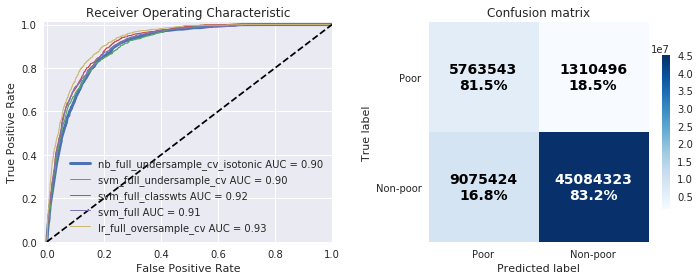

,nb_full_undersample_cv_isotonic,svm_full_undersample_cv,svm_full_classwts,svm_full,lr_full_oversample_cv
accuracy,0.830389,0.787755,0.814011,0.884676,0.851611
recall,0.814746,0.863686,0.861987,0.00183853,0.838116
precision,0.388406,0.336774,0.369331,0.948268,0.427456
f1,0.526039,0.484592,0.517102,0.00366995,0.566159
cross_entropy,0.461016,0.41083,0.221189,0.229268,0.348544
roc_auc,0.901645,0.903882,0.915038,0.909888,0.925356
cohen_kappa,0.381322,0.342357,0.384742,0.00669955,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 23.98% 


In [12]:
from sklearn.calibration import CalibratedClassifierCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = CalibratedClassifierCV(SVC(probability=True), method='isotonic')
parameters = {'base_estimator__C': 10**np.linspace(-10,1,20)}

model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full_undersample_cv',
                                                    'svm_full_classwts',
                                                    'svm_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='nb_full_undersample_cv_isotonic', 
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# SVM Indonesia Summary <a class="anchor" id="summary"></a>



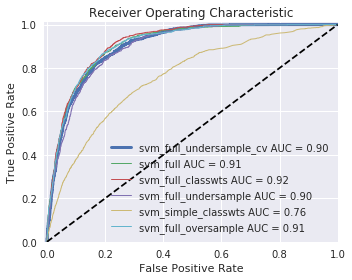

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
svm_full_undersample_cv,0.787755,0.863686,0.336774,0.484592,0.41083,0.903882,0.342357,0.179629
svm_full,0.884676,0.00183853,0.948268,0.00366995,0.229268,0.909888,0.00669955,-0.113541
svm_full_classwts,0.814011,0.861987,0.369331,0.517102,0.221189,0.915038,0.384742,0.150066
svm_full_undersample,0.808796,0.832707,0.358848,0.501555,0.376842,0.8967,0.32636,0.149984
svm_simple_classwts,0.721134,0.662492,0.193844,0.299929,0.265608,0.758437,0.186421,0.239762
svm_full_oversample,0.867253,0.755508,0.455099,0.568031,0.305525,0.909297,0.454544,0.0748775


In [13]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)